In [30]:
import pandas as pd

df = pd.read_csv("/kaggle/input/patents/patent_corpus.csv")

In [4]:
df.shape

(67068, 3)

In [31]:
SEED = 42

## Disclaimer: 
The code for section 2 had to be run in a kaggle notebook to leverage the GPUs available in the free tier. GPU RAM is limited in the free tier so we could not perfrom hyperparameter tuning or cross-validation as we could not load the evaluation data into RAM while training the SetFit models.

Check if GPU is available: 

In [4]:
import torch
print("PyTorch GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch GPU Available: True
GPU Name: Tesla T4


## Data Preperation

In [32]:
# subset df for only text and label
df = df[['abstract', 'label']]

Here we create our FewShot dataset consisting of 32 labeled abstracts. It is balanced across classes.

In [33]:
import numpy as np


# Always add a stable row_id column *once*
df["row_id"] = np.arange(len(df))

# ------------------------------------------------------------
# 1)  Build the balanced 32-shot TRAIN set
# ------------------------------------------------------------
labels        = sorted(df["label"].unique())
n_labels      = len(labels)          # 9
base          = 32 // n_labels       # → 3
remainder     = 32 - base * n_labels # → 5 extra shots

np.random.seed(SEED)
extra_labels  = np.random.choice(labels, size=remainder, replace=False)

def sample_k(grp):
    k = base + (1 if grp.name in extra_labels else 0)
    return grp.sample(k, random_state=SEED)

train_df = (
    df.groupby("label", group_keys=False)
      .apply(sample_k)
      .reset_index(drop=True)
)

print("TRAIN label counts\n", train_df["label"].value_counts())

TRAIN label counts
 label
a    4
b    4
y    4
h    4
f    4
e    3
d    3
c    3
g    3
Name: count, dtype: int64


/tmp/ipykernel_35/2730367519.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sample_k)


In [34]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, Features, Value, ClassLabel

# ------------------------------------------------------------
# 2)  Everything else → TEMP pool
# ------------------------------------------------------------
temp_df = df.loc[~df["row_id"].isin(train_df["row_id"])].reset_index(drop=True)

# When you make eval_df and test_holdout_df
eval_df, test_holdout_df = train_test_split(
    temp_df,
    test_size=0.90,
    stratify=temp_df["label"],
    random_state=SEED
)
eval_df         = eval_df.reset_index(drop=True)        # <—
test_holdout_df = test_holdout_df.reset_index(drop=True)


# ------------------------------------------------------------
# 4)
# ------------------------------------------------------------
# treat test_holdout_df as “unlabeled” by removing the ground-truth labels
pseudo_pool_df = (
    test_holdout_df
      .drop(columns=["label"])     # <-- removes the gold labels
      .reset_index(drop=True)      # keep a clean index
)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [35]:
# ------------------------------------------------------------
# 5)  Convert each to HF Dataset  (future-proof & RAM-safe)
# ------------------------------------------------------------
feature_spec = Features({
    "text" : Value("string"),
    "label": ClassLabel(names=labels),
    "row_id": Value("int64")
})

# Create a feature spec for the pseudo_pool_ds which does not have a 'label' column
pseudo_pool_feature_spec = Features({
    "text" : Value("string"),
    "row_id": Value("int64")
})

train_ds        = Dataset.from_pandas(train_df.rename(columns={"abstract":"text"}),        features=feature_spec)
eval_ds         = Dataset.from_pandas(eval_df.rename(columns={"abstract":"text"}),         features=feature_spec)
test_holdout_ds = Dataset.from_pandas(test_holdout_df.rename(columns={"abstract":"text"}), features=feature_spec)
# Use the pseudo_pool_feature_spec for the pseudo_pool_df
pseudo_pool_ds  = Dataset.from_pandas(pseudo_pool_df.rename(columns={"abstract":"text"}),  features=pseudo_pool_feature_spec)

print("HF splits ready:",
      len(train_ds), len(eval_ds), len(test_holdout_ds), len(pseudo_pool_ds))

HF splits ready: 32 6703 60333 60333


Now we have created the FewShot train_ds, eval_ds and pseudo_pool_ds which consists of 60000 unlabeled abstracts. We will later use these to create pseudo labled data. We chose eval to only hold 10% of the total data due to run time limitations.

In [10]:
!pip -q install "torch>=2.1" transformers datasets setfit accelerate evaluate sentinel sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

# Few Shot Learning with SetFit

Now we are going to train a SetFit model on the 32 sample abstracts.

SetFit (Sentence Transformer Fine-tuning) adapts a pre-trained sentence-embedding model to a new classification task with only a handful of labels—and does so very economically. It first converts the small labeled set into thousands of pairwise “similar vs. dissimilar” examples (positive = same label, negative = different) and performs a brief contrastive fine-tuning that reshapes the embedding space for the task. This step updates only a fraction of the transformer’s parameters and runs for a few epochs, so training typically finishes in minutes on a single GPU—or even comfortably on a CPU—while consuming far less memory than full model fine-tuning. Afterward, the encoder is frozen and a lightweight classifier (e.g., logistic regression) is fitted on the task-specific embeddings. The result is a model that achieves strong few-shot accuracy without the heavy compute or lengthy training cycles of traditional transformer fine-tuning. Especially the computational efficiency and strong performance with limited data make it a fitting choice for the given task.

### Using MiniLM sentence embeddings

Here we are going to train the SetFit model using the all-MiniLM-L6-v2 Sentence Transformer.  all-MiniLM-L6-v2 is a 6-layer, 22 M-parameter SentenceTransformer that distills larger models into 384-dimensional sentence embeddings making it computationally very efficient.

In [11]:
##############################################################
# 0) Imports, reproducibility, device
##############################################################
import pandas as pd
import numpy as np
import random
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset, Features, Value, ClassLabel
from setfit import SetFitModel, Trainer        # SetFit ≥ 0.8
import evaluate
import logging

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()]
)


2025-06-15 18:00:41.487585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750010441.944392      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750010442.063538      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [120]:
##############################################################
# 4) Load a smaller/faster encoder: MiniLM
##############################################################
import os
os.environ["WANDB_DISABLED"] = "true"

from setfit import SetFitModel

LABELS = train_ds.features["label"].names

BASE_ENCODER = 'all-MiniLM-L6-v2' #"AI-Growth-Lab/PatentSBERTa"

model = SetFitModel.from_pretrained(BASE_ENCODER, labels=LABELS)
model.to(DEVICE)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [121]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size=64,
    num_epochs=(20,4),

    eval_strategy="no"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [122]:

from setfit import Trainer
from sentence_transformers.losses import CosineSimilarityLoss


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    #eval_dataset=eval_ds
)
# 5) Train!
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 908
  Batch size = 64
  Num epochs = 20


Step,Training Loss
1,0.164400
50,0.120600
100,0.030900
150,0.012400


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [123]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    # a list of ~10% of your data
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.36      0.46      0.40       967
           b       0.24      0.25      0.24       897
           c       0.64      0.25      0.36       561
           d       0.19      0.30      0.23        56
           e       0.11      0.17      0.13       191
           f       0.20      0.57      0.30       475
           g       0.55      0.16      0.25      1438
           h       0.48      0.40      0.44      1427
           y       0.11      0.16      0.13       691

    accuracy                           0.30      6703
   macro avg       0.32      0.30      0.28      6703
weighted avg       0.39      0.30      0.31      6703



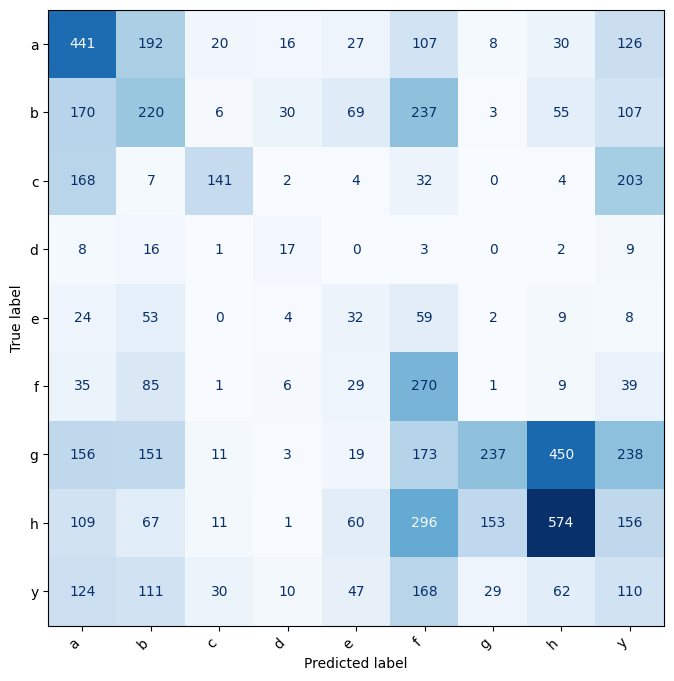

In [124]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

In [125]:

# we save the model as it is our best one so far
save_dir = "best_setfit_fewshot_model"          # any folder name you like
model.save_pretrained(save_dir)         # writes encoder, classifier + config
print(f"Model saved to {save_dir}/")

Model saved to best_setfit_fewshot_model/


### SetFit with Patent SBERta

We are now going to train the SetFit model using the PatentSBERTa Sentence Transformer.
PatentSBERTa is a domain-specialized SentenceTransformer built on a RoBERTa-base backbone (~125 M parameters, 768-dimensional embeddings) and fine-tunedon millions of patent-citation pairs, so it should capture technical aspects  and IPC semantics much more precisely than general-purpose models. However, it uses  roughly 6× more memory and latency, making MiniLM preferable when speed or resource budgets.

In [113]:
##############################################################
# 4) Load a smaller/faster encoder: PatentSBERTa-base
##############################################################
import os
os.environ["WANDB_DISABLED"] = "true"

from setfit import SetFitModel

LABELS = train_ds.features["label"].names

BASE_ENCODER = "AI-Growth-Lab/PatentSBERTa"
model = SetFitModel.from_pretrained(BASE_ENCODER, labels=LABELS)
model.to(DEVICE)

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Due to RAM limitations when using the more memory heavy PatentSBerta embeddings we have to decrease Batch size now and will also reduce the number of epochs.

In [115]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size=16,
    num_epochs=(6,2),
    eval_strategy="no"
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Due to RAM limitations we cannot evaluate during training.

In [117]:
# 4) Initialize the trainer
from setfit import Trainer
from sentence_transformers.losses import CosineSimilarityLoss


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    #eval_dataset=eval_ds,
    metric = "f1"
)
# 5) Train!
trainer.train()



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 908
  Batch size = 16
  Num epochs = 6


Step,Training Loss
1,0.179400
50,0.110200
100,0.018600
150,0.006900


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [118]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    # a list of ~10% of your data
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)


Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.24      0.34      0.28       967
           b       0.25      0.24      0.25       897
           c       0.41      0.32      0.36       561
           d       0.08      0.20      0.11        56
           e       0.09      0.17      0.12       191
           f       0.22      0.40      0.29       475
           g       0.53      0.26      0.35      1438
           h       0.50      0.37      0.43      1427
           y       0.11      0.14      0.13       691

    accuracy                           0.29      6703
   macro avg       0.27      0.27      0.26      6703
weighted avg       0.35      0.29      0.31      6703



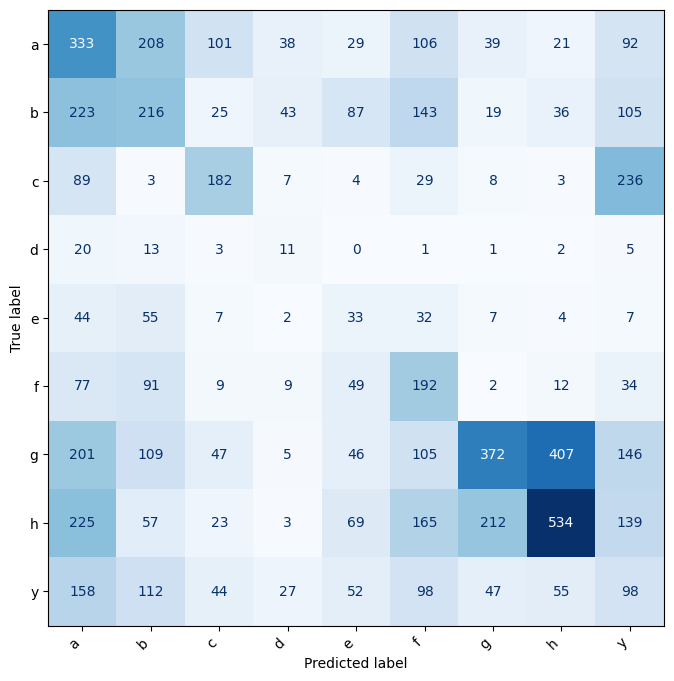

In [119]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

Slightly worse than with the MiniLM embeddings and much longer runtime. From on we will stick to the MiniLM Sentence Transformer.

# Creating more data - pseudo labeling



Now we are going to use the SetFit model trained earlier to predict the labels of some unlabeled abstracts. We then keep those predictions whose class-probability is very high (e.g., ≥ 90 %) and add these as "pseudo-labled" data to our original training set.


In [127]:
model = SetFitModel.from_pretrained("/kaggle/working/best_setfit_fewshot_model")

In [130]:
texts = pseudo_pool_ds["text"]
probs = model.predict_proba(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/943 [00:00<?, ?it/s]

This step turns each raw probability vector into a single “confidence” score (the highest class probability) and its corresponding predicted label, then discards any examples where the model is less than 90 % sure.

In [146]:
# 1) Attach your probs back onto the Dataset
#    (probs is an [N,9] NumPy array, texts = sub_pseudo_ds["text"])
scored_ds = sub_pseudo_ds.add_column(
    "probs",
    [row.tolist() for row in probs]   # one list[float] per example
)

import numpy as np

def add_conf_pred(batch):
    p = np.array(batch["probs"])
    batch["confidence"] = p.max(axis=1).tolist()
    batch["pred_label"] = p.argmax(axis=1).tolist()
    return batch

scored_ds = scored_ds.map(add_conf_pred, batched=True)

THRESH = 0.7
pseudo_ds = scored_ds.filter(lambda ex: ex["confidence"] >= THRESH)
print("High-confidence rows:", len(pseudo_ds))

Flattening the indices:   0%|          | 0/60333 [00:00<?, ? examples/s]

Map:   0%|          | 0/60333 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60333 [00:00<?, ? examples/s]

High-confidence rows: 547


In [147]:
import pandas as pd

# 1) Pull out the predicted label IDs
pred_ids = pseudo_ds["pred_label"]

# 2) Turn into a Pandas Series and count
dist = pd.Series(pred_ids).value_counts().sort_index()

# 3) (Optional) map back to your human-readable label names
label_names = train_ds.features["label"].names
dist.index = [label_names[i] for i in dist.index]

print("High-confidence pseudo-label distribution:")
print(dist)

High-confidence pseudo-label distribution:
a     47
b      7
c     30
d      1
e     14
f    254
g     61
h    124
y      9
Name: count, dtype: int64


unfortuenately we produce just on high confidence label for class d. We do not want to lower the threshold though as to not introduce too much noise. We will pick the top 10 abstracts per label that meet the confidence threshold as pseudo labeled data.

In [148]:
import pandas as pd
import numpy as np
from datasets import Dataset, concatenate_datasets
from collections import Counter

# 1) Convert pseudo_ds to a Pandas DataFrame
pseudo_df = pseudo_ds.to_pandas()

# 2) For each predicted label, pick the 10 rows with highest confidence
top10_df = (
    pseudo_df
    .groupby('pred_label', group_keys=False)
    .apply(lambda grp: grp.nlargest(10, 'confidence'))
    .reset_index(drop=True)
)

top10_df_clean = top10_df[["text", "pred_label"]].rename(columns={"pred_label":"label"})

/tmp/ipykernel_35/3253376384.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.nlargest(10, 'confidence'))


In [149]:
start_id = max(train_ds["row_id"]) + 1
top10_df_clean["row_id"] = np.arange(start_id, start_id + len(top10_df_clean))

top10_ds = Dataset.from_dict(
    {
        "text":  top10_df_clean["text"].tolist(),
        "label": top10_df_clean["label"].tolist(),
        "row_id": top10_df_clean["row_id"].tolist()
    }
).cast(train_ds.features)        # make label → ClassLabel

Casting the dataset:   0%|          | 0/77 [00:00<?, ? examples/s]

In [150]:
big_train_ds = concatenate_datasets([train_ds, top10_ds])  # 32 + 90 = 122 rows

Lets train with the new data

In [153]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size=64,
    num_epochs=(6,None),

    eval_strategy="no"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [151]:
import os
os.environ["WANDB_DISABLED"] = "true"

from setfit import SetFitModel

LABELS = train_ds.features["label"].names

BASE_ENCODER = 'all-MiniLM-L6-v2' #"AI-Growth-Lab/PatentSBERTa"
model = SetFitModel.from_pretrained(BASE_ENCODER, labels=LABELS)
model.to(DEVICE)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [154]:

from setfit import Trainer
from sentence_transformers.losses import CosineSimilarityLoss


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=big_train_ds,
    #eval_dataset=eval_ds,
    metric = "f1"
)
# 5) Train!
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/109 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 10480
  Batch size = 64
  Num epochs = 6


Step,Training Loss
1,0.187500
50,0.140800
100,0.036800
150,0.007600
200,0.003600
250,0.002200
300,0.001500
350,0.001300
400,0.001200
450,0.001000


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [155]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    # a list of ~10% of your data
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.40      0.48      0.44       967
           b       0.25      0.15      0.18       897
           c       0.56      0.28      0.38       561
           d       0.14      0.12      0.13        56
           e       0.11      0.31      0.16       191
           f       0.19      0.57      0.28       475
           g       0.54      0.29      0.37      1438
           h       0.49      0.34      0.40      1427
           y       0.13      0.17      0.15       691

    accuracy                           0.31      6703
   macro avg       0.31      0.30      0.28      6703
weighted avg       0.39      0.31      0.33      6703



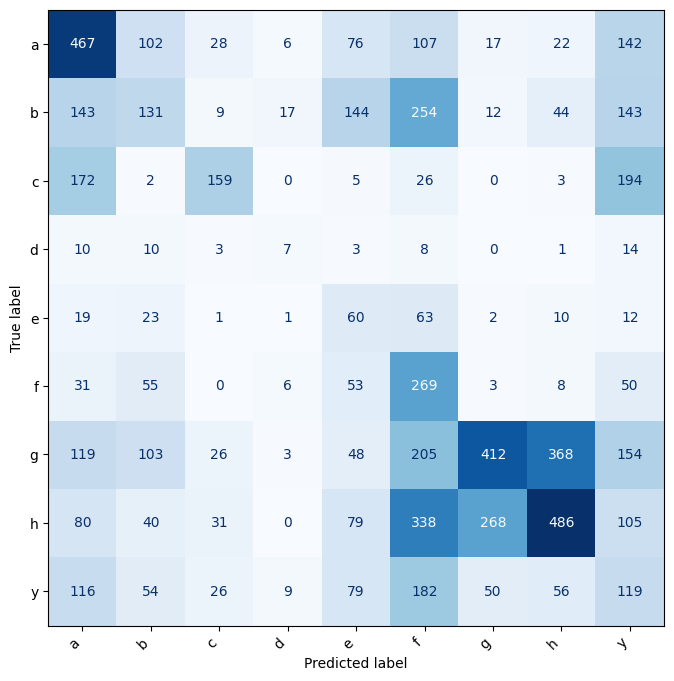

In [156]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

Again similar overall and across label performance as the original SetFit fewshot model, no real improvement.

# Zero Shot with LLM

This section is done in a seperate notebook. As we are accessing the LLM through the Mistral Api on the free tier we are limited to one request per second so we ran this in a seperate notebook for time efficiency.

# Data Generation with LLM

In this section we are going to generate additional training data by leveraging the Mistral model mistral-small-latest available through the api on the free tierto create labeled patent abstracts.

In [13]:
!pip install -qU litellm tqdm
import os

# ── 1.  API key & model -------------------------------------------------
os.environ["MISTRAL_API_KEY"] = "1jwUcSzw7IwGdusNjHmnmKfMuWpf4qg3"        #  ← paste your key here
MODEL = "mistral/mistral-small-latest"

In [15]:
import os, re, time, json, random
from tqdm.auto import tqdm
from litellm import completion

IPC_SECTIONS = {
    "A": "Human Necessities",
    "B": "Performing Operations; Transporting",
    "C": "Chemistry; Metallurgy",
    "D": "Textiles; Paper",
    "E": "Fixed Constructions",
    "F": "Mechanical Engineering; Lighting; Heating; Weapons; Blasting",
    "G": "Physics",
    "H": "Electricity",
    "Y": "General tagging of new or cross-sectional technology"
}

SYSTEM_GEN = (
    "You are a patent attorney.\n"
    "Generate *one* plausible patent **abstract** (120-180 words) that fits "
    "exactly into the given IPC section. "
    "Use technical language, mention a novel element, but avoid claims or legal boiler-plate. "
    "Return only the abstract text.\n"
)


def generate_one(code, temp=1.0):
    prompt = (
        f"Section {code} – {IPC_SECTIONS[code]}.\n"
        f"Write the abstract now:"
    )
    resp = completion(
        model=MODEL,
        api_key=os.getenv("MISTRAL_API_KEY"),
        messages=[{"role":"system","content":SYSTEM_GEN},
                  {"role":"user"  ,"content":prompt}],
        temperature=temp,
        max_tokens=220
    )
    return resp.choices[0].message.content.strip()

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_config.py:323: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)


In [16]:
import pandas as pd, numpy as np

synth_rows = []
for sec in IPC_SECTIONS:                                   # loop A…Y
    for _ in tqdm(range(20), desc=f"IPC {sec}"):
        try:
            txt = generate_one(sec)
            synth_rows.append({"text": txt, "label": sec})
        except Exception as e:                          # network hiccup
            print("retry", e); time.sleep(2); continue
        time.sleep(1.0)                    # stay < 60 req/min

synth_df = pd.DataFrame(synth_rows).drop_duplicates("text")
print("Synthetic rows:", len(synth_df))
synth_df.head()

IPC A:   0%|          | 0/20 [00:00<?, ?it/s]

18:20:43 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:20:45 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:20:45 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:20:45 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
/usr/local/lib/python3.11/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 5: Expected `Message` - serialized value may not be as expected [input_value=Message(content='A wearab...ields={'refusal': None}), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.

IPC B:   0%|          | 0/20 [00:00<?, ?it/s]

18:21:44 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:21:46 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:21:46 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:21:46 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
/usr/local/lib/python3.11/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 5: Expected `Message` - serialized value may not be as expected [input_value=Message(content='A system...ields={'refusal': None}), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.

IPC C:   0%|          | 0/20 [00:00<?, ?it/s]

18:22:44 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:22:46 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:22:46 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:22:46 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:22:46 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:22:47 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:22:50 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:22:50 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:22:50 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-

IPC D:   0%|          | 0/20 [00:00<?, ?it/s]

18:23:49 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:23:50 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:23:50 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:23:50 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:23:50 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:23:51 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:23:53 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:23:53 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:23:53 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-

IPC E:   0%|          | 0/20 [00:00<?, ?it/s]

18:24:50 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:24:51 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:24:51 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:24:51 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:24:51 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:24:52 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:24:54 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:24:54 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:24:54 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-

IPC F:   0%|          | 0/20 [00:00<?, ?it/s]

18:25:49 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:25:52 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:25:52 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:25:52 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:25:52 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:25:53 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:25:54 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:25:54 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:25:54 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-

IPC G:   0%|          | 0/20 [00:00<?, ?it/s]

18:26:43 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:26:44 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:26:44 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:26:44 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:26:44 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:26:45 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:26:46 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:26:46 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:26:46 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-

IPC H:   0%|          | 0/20 [00:00<?, ?it/s]

18:27:41 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:27:43 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:27:43 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:27:43 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:27:43 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:27:44 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:27:45 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:27:45 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:27:45 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-

IPC Y:   0%|          | 0/20 [00:00<?, ?it/s]

18:28:35 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:28:36 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:28:36 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:28:36 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:28:36 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:28:37 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:28:39 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:28:39 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
18:28:39 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-

Synthetic rows: 180


,text,label
0,A wearable device for monitoring and managing ...,A
1,"A novel, wearable device designed for continuo...",A
2,A novel personal hygiene device designed for e...,A
3,A novel wearable device for real-time monitori...,A
4,A wearable device for monitoring and managing ...,A


In [31]:
# save to CSV
synth_df.to_csv("synthetic_patents.csv", index=False)

We store these in a csv to be used in later sessions.

In [17]:
synth_df = pd.read_csv("/kaggle/input/synthetic-patent/synthetic_patents.csv")

Let's inspect one example abstract for every label:

In [18]:
# Group by label and pick the first example for each
example_per_label = df.groupby("label").first().reset_index()

# Print each label with its example text
for _, row in example_per_label.iterrows():
    print(f"Label: {row['label']}\nText: {row['abstract']}\n{'-'*60}")

Label: a
Text: A visual axis detecting device includes an image sensor for imaging an eyeball image and a visual axis detector for detecting a Purkinje image from the eyeball image imaged by the image sensor as well as for extracting pupil edges from a plurality of pupil edge candidates contained in the eyeball image and detecting the visual axis of a user using the Purkinje image and the pupil edges. The visual axis detector defines a reference point from the position of the Purkinje image, determines the distances from the reference point to the plurality of pupil edge candidates, respectively, and extracts the pupil edges from the plurality of pupil edge candidates by statistically processing the distances. With this arrangement, the visual axis detecting device can correctly extract the pupil edges at a high speed.
------------------------------------------------------------
Label: b
Text: Polymer hydrogels adapted for use as soft contact lenses are treated to provide at least on t

These look quite promising overall. Only the abstract for label y seems like it is not that fitting. Category y (  "General tagging of new or cross-sectional technology") is in general quite a ambiguos class. Lets inspect the three abstracts we have in our training set.

In [28]:

# 1) build int → letter mapping
#
# If the "label" column was created with a ClassLabel feature,
# the mapping is already stored in `names`.
# Otherwise you must supply your own list like ['a','b',...,'y'].
#
label_names = train_ds.features["label"].names      # e.g. ['a','b',...,'y']
id2letter   = {i: name.upper() for i, name in enumerate(label_names)}
letter2id   = {v: k for k, v in id2letter.items()}

# 2) get the integer id for letter Y
y_id = letter2id["Y"]

# 3) filter and print abstracts whose label == y_id
y_subset = train_ds.filter(lambda ex: ex["label"] == y_id)

print(f"Found {len(y_subset)} abstracts in section Y\n")

for i, abstract in enumerate(y_subset["text"], 1):
    print(f"{i:02d}. {abstract}\n")

Filter:   0%|          | 0/32 [00:00<?, ? examples/s]

Found 4 abstracts in section Y

01. In order to burn a fuel of low ignition properties and low contents of volatile gases in steam generators: the combustion air is introduced in three batches at three successive places into the firebox. Preferably, the primary air is introduced at a temperature of at least about 500°, preferably between 500° and 600° C. so as to effect a pregasification of the fuel. The secondary air is then introduced at a temperature of about 350° to 400° C. to start the combustion of the pregasified fuel and the tertiary air is finally introduced at a temperature of only about 250° to 300° C. in order to complete the combustion. This temperature differentiation of heat ranges then will permit to withdraw theash as a dry discharge.

02. Microbial cells having active enzymes associated therewith are flocculated in the presence of certain metallic compounds to give flocculated cell aggregates exhibiting improved hardness. The cell aggregates are effective as immobiliz

It seems like these are a combination of two or more of the other classes. These will be pretty hard to identify by the model. For optimal technique application lets prompt the LLM with these as examples to generate a few more.

In [37]:
import os, time, random
import numpy as np
from tqdm.auto import tqdm
from litellm import completion

# -------------------------------------------------------------
# 0.  Four gold examples used as anchors
# -------------------------------------------------------------
EXAMPLES = [
    "In order to burn a fuel of low ignition properties and low contents of volatile gases in steam generators: the combustion air is introduced in three batches...",
    "Microbial cells having active enzymes associated therewith are flocculated in the presence of certain metallic compounds to give flocculated cell aggregates...",
    "An apparatus for depositing a thin film on a substrate and product produced thereby are disclosed. In particular, deposition of the thin film is carried out...",
    "The disclosure relates generally to processing audio and video signals. One claim recites an apparatus comprising: electronic memory for storing a media signal..."
]
example_block = "\n\n".join(f"EXAMPLE {i+1}:\n{txt}" for i, txt in enumerate(EXAMPLES))

# -------------------------------------------------------------
# 1.  Prompt pieces (Section-Y focused)
# -------------------------------------------------------------
SYSTEM_MSG = (
    "You are a senior patent attorney.\n"
    "Generate ONE new patent ABSTRACT (120-180 words) that clearly belongs to "
    "IPC Section Y – General tagging of new or cross-sectional technology.\n\n"
    "Section-Y inventions typically combine at least two disparate technical domains "
    "and employ emerging or enabling technologies (AI, IoT, green manufacturing, "
    "blockchain, bio-materials, etc.). State the inventive step and a system-level "
    "benefit such as sustainability, efficiency, or data integrity.\n"
    "Do NOT copy phrases longer than four words from the examples.\n"
    "Return ONLY the abstract text."
)

def generate_one_y(temp=1.0):
    prompt = (
        "SECTION: Y – General tagging of new or cross-sectional technology.\n\n"
        f"{example_block}\n"
        "----\n"
        "Now write the NEW abstract:"
    )
    resp = completion(
        model="mistral/mistral-small-latest",
        api_key=os.getenv("MISTRAL_API_KEY"),
        messages=[{"role": "system", "content": SYSTEM_MSG},
                  {"role": "user",   "content": prompt}],
        temperature=temp,
        max_tokens=220,
        seed=random.randint(1, 1_000_000)
    )
    return resp.choices[0].message.content.strip()

# -------------------------------------------------------------
# 2.  Generate 20 abstracts and store in a DataFrame
# -------------------------------------------------------------
rows = []
for _ in tqdm(range(20), desc="Generating Y abstracts"):
    rows.append({"text": generate_one_y(), "label": "y"})
    time.sleep(1.05)                     # free-tier rate-limit buffer

import pandas as pd
synth_y_df = pd.DataFrame(rows)
print(f"Generated {len(synth_y_df)} abstracts")
synth_y_df.head(3)

Generating Y abstracts:   0%|          | 0/20 [00:00<?, ?it/s]

13:46:16 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
13:46:17 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
13:46:17 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
13:46:17 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
/usr/local/lib/python3.11/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 5: Expected `Message` - serialized value may not be as expected [input_value=Message(content='A system...ields={'refusal': None}), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.

Generated 20 abstracts


,text,label
0,A system integrates Internet of Things (IoT) s...,y
1,A system for optimizing urban waste management...,y
2,A system integrates blockchain technology with...,y


In [43]:
print(synth_y_df.iloc[12:14].to_string(index=False))

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     text label
                                                                            A system for optimizing agricultural irrigation using a combination of Internet of Things (IoT) sensors, artificial intelligence (AI), and b

Well this didnt work too well. They are all pretty similar. Let's try again with a prompt fine tuned with GPTo3

In [19]:
# ===============================================================
#  Generate 20 diverse Section-Y abstracts with domain rotation
# ===============================================================
import os, time, random, itertools
import pandas as pd
from tqdm.auto import tqdm
from litellm import completion

MODEL            = "mistral/mistral-small-latest"
RATE_LIMIT_SLEEP = 1.05                      # free-tier safety buffer

# ---------- 1. Expanded domain-pair pool ------------------------
DOMAIN_PAIRS = [
    # green / sustainability blends
    "carbon-negative concrete with AI-optimised curing",
    "waste-heat recovery fused with thermoelectric polymers",
    "ocean-wave energy harvesting using piezoelectric textiles",
    # bio-tech crossovers
    "bio-catalysis combined with metal-organic frameworks",
    "real-time DNA sequencing coupled to edge computing",
    "synthetic biology fuel cells powering agricultural robots",
    # quantum / security
    "quantum-safe cryptography for autonomous drone fleets",
    "quantum sensor arrays integrated with geophysical mapping",
    # advanced materials
    "adaptive thin-film manufacturing with acoustic metamaterials",
    "graphene aerogels combined with AI structural monitoring",
    # data / AI crossovers
    "federated learning for remote medical imaging devices",
    "neuromorphic chips embedded in smart textiles",
    # circular economy
    "chemical recycling orchestrated by IoT machine vision",
    "bio-based polymer upcycling via plasma reforming",
    # food & agri
    "precision aquaculture guided by hyperspectral drones",
    "vertical-farm robotics enhanced by plant-phenomics AI",
    # transport & logistics
    "hydrogen powered unmanned cargo airships with blockchain telemetry",
    "smart container liners measuring spoilage with enzymatic sensors",
    # healthcare tech
    "electroceutical wound dressings linked to cloud analytics",
    "VR-based physiotherapy paired with haptic exoskeleton gloves",
    # extra buffer entries
    "lithium-sulfur batteries monitored by digital twin models",
    "space debris capture nets with AI trajectory planning",
    "solid-state cooling integrated with photonic crystals"
]

# ---------- 2. System prompt (no example block) -----------------
SYSTEM_MSG = (
    "You are a senior patent attorney.\n"
    "Generate ONE new patent ABSTRACT (120–180 words) that belongs to "
    "IPC Section Y – General tagging of new or cross-sectional technology.\n\n"
    "Each abstract must explicitly combine the two technical domains given "
    "in the hint below, highlight the emerging technology, and state a clear "
    "inventive benefit (efficiency, sustainability, interoperability, etc.).\n"
    "Avoid boiler-plate claims wording and return ONLY the abstract text."
)

def generate_one_y(domain_hint, temp=1.1, top_p=0.9):
    user_prompt = (
        f"SECTION Y – General tagging of new or cross-sectional technology.\n"
        f"Target domain pairing: {domain_hint}.\n\n"
        "Write the new abstract now:"
    )
    resp = completion(
        model           = MODEL,
        api_key         = os.getenv("MISTRAL_API_KEY"),
        messages        = [
            {"role": "system", "content": SYSTEM_MSG},
            {"role": "user",   "content": user_prompt}
        ],
        temperature     = temp,
        top_p           = top_p,
        max_tokens      = 220,
        seed            = random.randint(1, 1_000_000)
    )
    return resp.choices[0].message.content.strip()

# ---------- 3. Round-robin over domain pairs -------------------
pairs_cycle = itertools.cycle(random.sample(DOMAIN_PAIRS, len(DOMAIN_PAIRS)))
rows = []

for _ in tqdm(range(20), desc="Generating Y abstracts"):
    domain_hint = next(pairs_cycle)
    abstract    = generate_one_y(domain_hint)
    rows.append({"text": abstract, "label": "y"})
    time.sleep(RATE_LIMIT_SLEEP)

synth_y_df = pd.DataFrame(rows)
print("Generated DataFrame shape:", synth_y_df.shape)
synth_y_df.head(3)

Generating Y abstracts:   0%|          | 0/20 [00:00<?, ?it/s]

18:30:45 - LiteLLM:INFO: utils.py:3119 - 
LiteLLM completion() model= mistral-small-latest; provider = mistral
18:30:47 - LiteLLM:INFO: utils.py:1215 - Wrapper: Completed Call, calling success_handler
18:30:47 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-small-latest
/usr/local/lib/python3.11/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 5: Expected `Message` - serialized value may not be as expected [input_value=Message(content='A method...ields={'refusal': None}), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
18:30:47 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: mistral/mistral-sm

Generated DataFrame shape: (20, 2)


,text,label
0,A method and system for producing carbon-negat...,y
1,A system and method for adaptive thin-film man...,y
2,A quantum-enhanced geophysical mapping system ...,y


In [20]:
print(synth_y_df.iloc[12:16].to_string(index=False))

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text label
A neuromorphic smart textile system integrate

In [21]:
# save to CSV for later usage
synth_y_df.to_csv("synthetic_patents_y.csv", index=False)

In [40]:
synth_y_df = pd.read_csv("/kaggle/working/synthetic_patents_y.csv")

These look more promising lets use them.

In [37]:
synth_df = pd.read_csv("/kaggle/input/synthetic-patent/synthetic_patents.csv")

In [41]:
from datasets import Dataset, concatenate_datasets, ClassLabel



# Convert to a Dataset ------------------------------------------------
synth_ds = Dataset.from_pandas(
    synth_df[["text", "label"]],
    preserve_index=False
)

#  Ensure the label feature has the SAME type as in train_ds ----------
# ‣ Case A: train_ds.label is already int64 0-8 → nothing to do.
# ‣ Case B: train_ds.label is a ClassLabel with string names → cast:

if isinstance(train_ds.features["label"], ClassLabel):
    # build identical ClassLabel for synth_ds
    synth_ds = synth_ds.cast_column(
        "label",
        ClassLabel(names=train_ds.features["label"].names)
    )

# Concatenate --------------------------------------------------------
llm_train_ds = concatenate_datasets([train_ds, synth_ds])

print(llm_train_ds)                 

Casting the dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'row_id'],
    num_rows: 212
})


Now we replace the original synthetic abstracts of category y with the fine-tuned ones.

In [42]:
from datasets import Dataset, concatenate_datasets

# 1️⃣  Get the label↔id mapping and Y’s id
label_names = llm_train_ds.features["label"].names       # ['a','b', … ,'y']
y_id        = {n.upper(): i for i, n in enumerate(label_names)}["Y"]

# 2️⃣  Collect the *original* Y abstracts (4 rows) from train_ds
orig_y_texts = set(
    train_ds
    .filter(lambda ex: ex["label"] == y_id)["text"]
)

# 3️⃣  Drop every Y row in llm_train_ds **except** those originals
def keep_row(example):
    return (example["label"] != y_id) or (example["text"] in orig_y_texts)

llm_no_synth_y = llm_train_ds.filter(keep_row)

# 4️⃣  Convert your 20 new abstracts → HF Dataset (same schema)
synth_y_ds = Dataset.from_pandas(
    synth_y_df.rename(columns={"text": "text", "label": "label"}),
    preserve_index=False
).cast_column("label", llm_no_synth_y.features["label"])   # keep ClassLabel dtype

# 5️⃣  Concatenate and shuffle
modified_llm_train_ds = concatenate_datasets([llm_no_synth_y, synth_y_ds]).shuffle(seed=42)

print("original llm_train_ds size :", len(llm_train_ds))
print("after Y-replacement        :", len(modified_llm_train_ds))
print("Y rows kept from originals :", len(orig_y_texts))
print("new Y rows added           :", len(synth_y_ds))

Filter:   0%|          | 0/32 [00:00<?, ? examples/s]

Filter:   0%|          | 0/212 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

original llm_train_ds size : 212
after Y-replacement        : 212
Y rows kept from originals : 4
new Y rows added           : 20


### Lets train the SetFit model with original the synthetic data:

In [76]:
import os
os.environ["WANDB_DISABLED"] = "true"

from setfit import SetFitModel

LABELS = train_ds.features["label"].names

BASE_ENCODER = 'all-MiniLM-L6-v2' #"AI-Growth-Lab/PatentSBERTa"
model = SetFitModel.from_pretrained(BASE_ENCODER, labels=LABELS)
model.to(DEVICE)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [77]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size=96,
    num_epochs=(2,2),
    eval_strategy="no"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [78]:
# 4) Initialize the trainer
from setfit import Trainer
from sentence_transformers.losses import CosineSimilarityLoss


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=llm_train_ds,
    #eval_dataset=eval_ds,
    metric = "f1"
)
# 5) Train!
trainer.train()



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/212 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 39948
  Batch size = 96
  Num epochs = 2


Step,Training Loss
1,0.192100
50,0.130000
100,0.046500
150,0.020700
200,0.009300
250,0.004400
300,0.002800
350,0.002300
400,0.002100


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [52]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.60      0.47      0.53       967
           b       0.34      0.30      0.32       897
           c       0.45      0.47      0.46       561
           d       0.08      0.75      0.14        56
           e       0.23      0.40      0.30       191
           f       0.31      0.54      0.40       475
           g       0.49      0.45      0.47      1438
           h       0.60      0.57      0.58      1427
           y       0.07      0.02      0.04       691

    accuracy                           0.42      6703
   macro avg       0.35      0.44      0.36      6703
weighted avg       0.44      0.42      0.42      6703



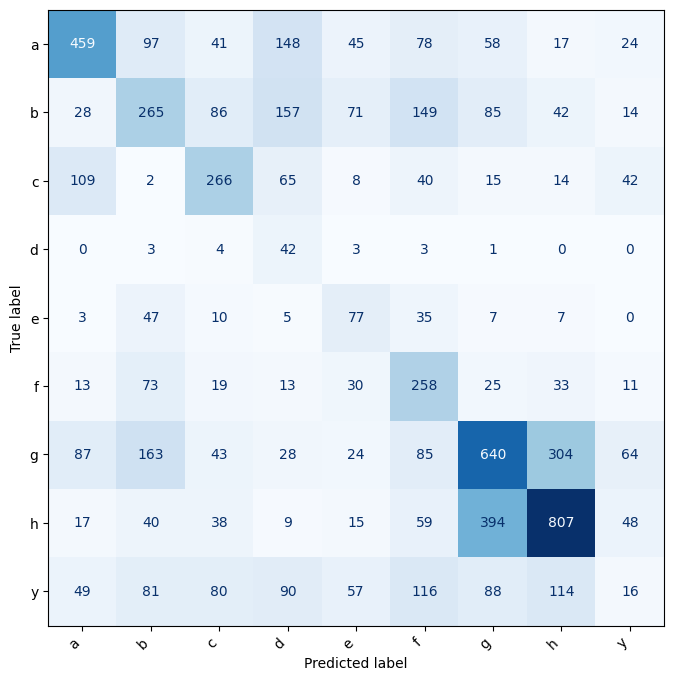

In [82]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

Best performance so far! As expected however,  the model is unable to identify label y. Let's see if it performs better with the fine-tuned snythetic y abstracts.

In [83]:

# we save the model as it is our best one so far
save_dir = "best_setfit_model"          # any folder name you like
model.save_pretrained(save_dir)         # writes encoder, classifier + config
print(f"Model saved to {save_dir}/")

Model saved to best_setfit_model/


### Let`s use the new y abstracts

In [54]:
import os
os.environ["WANDB_DISABLED"] = "true"

from setfit import SetFitModel

LABELS = train_ds.features["label"].names

BASE_ENCODER = 'all-MiniLM-L6-v2'
model = SetFitModel.from_pretrained(BASE_ENCODER, labels=LABELS)
model.to(DEVICE)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [56]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size= 96,
    num_epochs= 2,
    eval_strategy="no"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [57]:
# 4) Initialize the trainer
from setfit import Trainer
from sentence_transformers.losses import CosineSimilarityLoss


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=modified_llm_train_ds,
    #eval_dataset=eval_ds,
    metric = "f1"
)
# 5) Train!
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/212 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 39948
  Batch size = 96
  Num epochs = 2


Step,Training Loss
1,0.209300
50,0.144100
100,0.060100
150,0.020300
200,0.008200
250,0.004000
300,0.002800
350,0.002300
400,0.002000


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [81]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.62      0.37      0.46       967
           b       0.33      0.28      0.30       897
           c       0.52      0.41      0.46       561
           d       0.08      0.64      0.14        56
           e       0.21      0.36      0.26       191
           f       0.30      0.47      0.37       475
           g       0.46      0.28      0.35      1438
           h       0.60      0.49      0.54      1427
           y       0.10      0.19      0.13       691

    accuracy                           0.36      6703
   macro avg       0.36      0.39      0.33      6703
weighted avg       0.44      0.36      0.38      6703



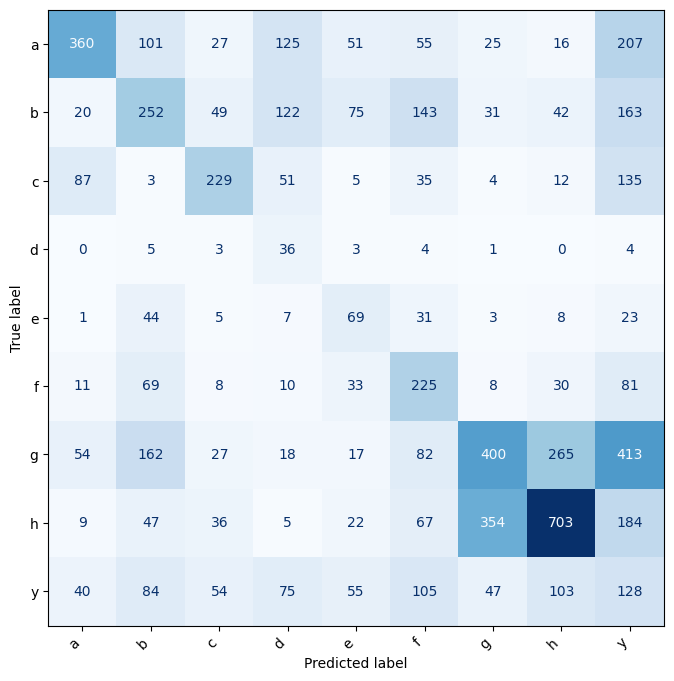

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

Now the model is a little better at detecting y abstracts. However, overall performance is slightly worse. 

# Optimal Technique Application

As our optimal technique we setteled on using the 32 labeled abstracts plus the orginal 180 LLM generated abstracts. In this part we import the best model from above and do hyperparameter tuning on the classifier head to see if we can squeeze out a little more performance.

In [84]:
############################################################
# 0 · Prereqs (CPU-only is fine for everything below)
############################################################
!pip install  scikit-learn

from setfit import SetFitModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

############################################################
# 1 · Load or fine-tune your encoder once
############################################################
model = SetFitModel.from_pretrained("/kaggle/working/best_setfit_model")   # or train here


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [85]:
from setfit import SetFitModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

# ── 2 · Embed your full labelled pool once (CPU or GPU) ───────────
X_train = model.encode(llm_train_ds["text"],       # list/Series of strings
                       batch_size=64,             # adjust to VRAM/RAM
                       show_progress_bar=True)
y_train = llm_train_ds["label"]


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [99]:
# ── 3 · Hyper-parameter search for logistic-regression head ───────
# ── Hyper-parameter grid ──────────────────────────────────────────
param_grid = {
    "solver": ["liblinear"],           # robust on small→medium sets
    "penalty": ["l1", "l2"],           # sparsity vs. standard ridge
    "C": np.logspace(-4, 4, 9),
    "max_iter": [500, 1000, 2000]
}

base_lr = LogisticRegression(
    multi_class="ovr",
    max_iter=1000,
    n_jobs=-1,
    verbose=0
)



cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = GridSearchCV(base_lr, param_grid, scoring="f1_macro",
                      cv=cv, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
best_lr = search.best_estimator_

# ── 4 · Attach the tuned head back to the SetFit model ────────────
model.model_head = best_lr        # or: model.head = best_lr

model.save_pretrained("/kaggle/working/best_setfit_with_tuned_lr_3")

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  

Best params: {'C': 9.999999999999999e-05, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}


In [100]:
############################################################
# 1 · Reload the best checkpoint (encoder + tuned head)
############################################################
from setfit import SetFitModel
model = SetFitModel.from_pretrained("/kaggle/working/best_setfit_with_tuned_lr_3")
model.model_head


LogisticRegression(C=9.999999999999999e-05, max_iter=500, multi_class='ovr',
                   n_jobs=-1, solver='liblinear')

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1) Extract texts & true labels from your subsample
texts  = eval_ds["text"]    
labels = eval_ds["label"]

# 2) Run SetFitModel.predict with a small batch
#    (this under the hood does encode → classify in batches)
preds = model.predict(texts, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           a       0.59      0.50      0.54       967
           b       0.33      0.30      0.32       897
           c       0.47      0.46      0.47       561
           d       0.08      0.75      0.15        56
           e       0.23      0.38      0.29       191
           f       0.30      0.55      0.39       475
           g       0.50      0.41      0.45      1438
           h       0.60      0.59      0.59      1427
           y       0.06      0.02      0.03       691

    accuracy                           0.42      6703
   macro avg       0.35      0.44      0.36      6703
weighted avg       0.44      0.42      0.42      6703



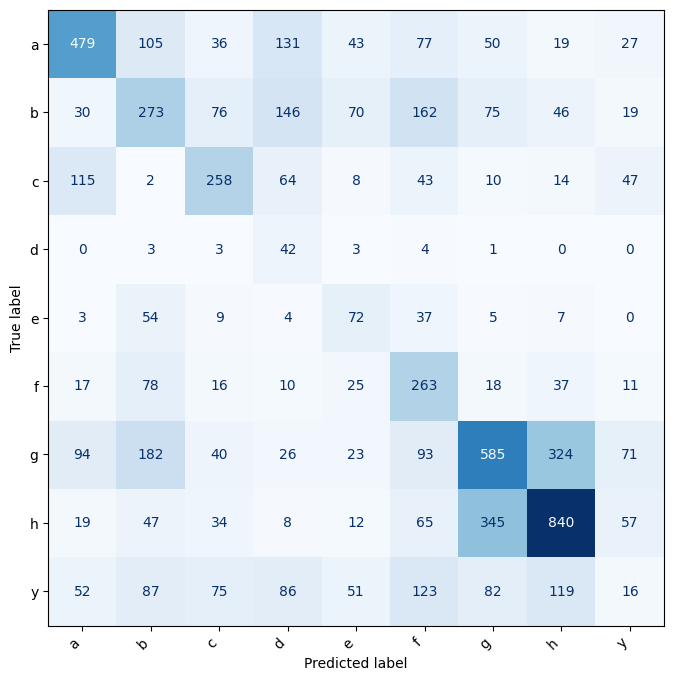

In [103]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Grab your label names (e.g. ["a","b",…,"y"])
label_names = eval_ds.features["label"].names

# If `labels` is numeric (0–8) and `preds` is string, map labels → names:
str_labels = [label_names[i] for i in labels]
str_preds  = preds if isinstance(preds[0], str) else [label_names[i] for i in preds]

# Now both are lists of strings:
print(classification_report(str_labels, str_preds, target_names=label_names))

# And confusion matrix
cm = confusion_matrix(str_labels, str_preds, labels=label_names)
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

The tuning of the logistic regression classifier actually did not change anything. So this is our final best model using only the 32 labeled abstracts.

# Conclusion

### Classification Report: Zero-Shot vs. Best SetFit

| Label | Precision (Zero-Shot) | Recall (Zero-Shot) | F1 (Zero-Shot) | Precision (SetFit) | Recall (SetFit) | F1 (SetFit) | Support |
|-------|------------------------|---------------------|----------------|---------------------|------------------|-------------|---------|
| a     | 0.71                   | 0.68                | 0.69           | 0.59                | 0.50             | 0.54        | 967     |
| b     | 0.64                   | 0.11                | 0.19           | 0.33                | 0.30             | 0.32        | 897     |
| c     | 0.60                   | 0.71                | 0.65           | 0.47                | 0.46             | 0.47        | 561     |
| d     | 0.27                   | 0.55                | 0.37           | 0.08                | 0.75             | 0.15        | 56      |
| e     | 0.44                   | 0.42                | 0.43           | 0.23                | 0.38             | 0.29        | 191     |
| f     | 0.25                   | 0.80                | 0.38           | 0.30                | 0.55             | 0.39        | 475     |
| g     | 0.58                   | 0.41                | 0.48           | 0.50                | 0.41             | 0.45        | 1438    |
| h     | 0.55                   | 0.82                | 0.66           | 0.60                | 0.59             | 0.59        | 1427    |
| y     | 0.12                   | 0.00                | 0.00           | 0.06                | 0.02             | 0.03        | 691     |

**Overall Metrics**

| Metric              | Zero-Shot | SetFit |
|---------------------|-----------|--------|
| Accuracy            | 0.51      | 0.42   |
| Macro Avg Precision | 0.46      | 0.35   |
| Macro Avg Recall    | 0.50      | 0.44   |
| Macro Avg F1        | 0.43      | 0.36   |
| Weighted Avg F1     | 0.47      | 0.42   |

Zero-Shot Classification out performed our best model trained on the 32 labeld abstracts plus the llm generated abstracts across all metrics and is similar in relative performance across labels. Both models are unable to classify the abstracts of class y:"General tagging of new or cross-sectional technology" as this class is inherently ambiguos. On our evaluation set consisting of 6700 abstracts the Zero-Shot classification however took around 3 hours to run accessing the Mistral Api on the free tier. Our SetFit model was trained using 180 llm generated abstracts which makes far less api calls (it took about 4 minutes to generate these). The model was also quite fast to train using the Kaggle free tier GPUs (about 10 minutes) making it much more efficient that the LLM classification. However, for both cases the performance is nowhere near good enough to be used in any business case.